# Task 1: Statevector Simulation of Quantum Circuits
For this task, you will implement a statevector simulator for quantum circuits from scratch. The goal is to demystify how to simulate a quantum computer and to demonstrate your familiarity with quantum circuits.

# 1) Naive Simulation Using Matrix Multiplication

Remember that $[1, 0] = |0\rangle$ is the most common representation of the single-qubit zero state, and analogously $[0, 1] = |1\rangle$.

Most matrix representations of quantum gates you can find online follow this convention. For example, the X gate can be written as:

\[
X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}
\]

Using the Kronecker product and the `np.kron` function in NumPy (we are using it as an example, but you can use any library you want to), you can create a vector of length $2^n$ representing an $n$-qubit quantum state, and matrix representations of $X$, $H$, and CNOT gates.

*Hint:* The single-qubit Identity matrix is:

\[
I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\]

Define a quantum circuit consisting of these gates and apply the gates sequentially to the statevector via matrix multiplication.

## Task

Plot the runtime of your code as a function of the number of qubits. How many qubits can you simulate this way?


# 1) Naive Simulation Using Matrix Multiplication

Remember that \([1, 0] = |0\rangle\) is the most common representation of the single-qubit zero state, and analogously \([0, 1] = |1\rangle\).

Most matrix representations of quantum gates you can find online follow this convention. For example, the X gate can be written as:

$$
X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}
$$


Using the Kronecker product and the `np.kron` function in NumPy (we are using it as an example, but you can use any library you want to), you can create a vector of length \(2^n\) representing an \(n\)-qubit quantum state, and matrix representations of \(\text{X}\), \(\text{H}\), and CNOT gates.

**Hint**: The single-qubit Identity matrix is:

$$
I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
$$

Define a quantum circuit consisting of these gates and apply the gates sequentially to the statevector via matrix multiplication.

### Task
Plot the runtime of your code as a function of the number of qubits. How many qubits can you simulate this way?

# 2) Advanced Simulation Using Tensor Multiplication
Tensors are generalizations of vectors and matrices to any number of dimensions. Instead of representing an n-qubit state as a vector of length 
, it may be more natural to write it as an n-dimensional tensor of shape 
. The transformations between these two representations are naturally possible via np.reshape and np.flatten.

Using tensor multiplication and the np.tensordot (or np.einsum) function, you can apply a gate to the quantum state by multiplying the 1- or 2-qubit matrices with the state tensor along the corresponding qubit axes.

Define a quantum circuit consisting of the 1- and 2-qubit matrix representations of X, H, and CNOT (same as above) and apply them sequentially to the quantum state tensor via tensor multiplication.

### Task
Plot the runtime of your code as a function of the number of qubits. How many qubits can you simulate this way? Compare your results to subtask 1.

In [17]:
!pip install memory-profiler

In [19]:
import os
import time
import numpy as np

import matplotlib.pyplot as plt

from memory_profiler import memory_usage

In [22]:
# Define quantum gates
def X_gate():
    return np.array([[0, 1], [1, 0]], dtype=complex)

def Z_gate():
    return np.array([[1, 0], [0, -1]], dtype=complex)

def H_gate():
    return np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)

def CNOT_gate():
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]], dtype=complex)

def I_gate():
    return np.array([[1, 0], [0, 1]], dtype=complex)

# Initialize statevector for n qubits
def initialize_statevector(n):
    return np.array([1] + [0] * (2**n - 1), dtype=complex)

# Apply single-qubit gate using matrix multiplication
def apply_single_qubit_gate(state, gate, qubit, n):
    operator = 1
    for i in range(n):
        operator = np.kron(operator, gate if i == qubit else I_gate())
    return operator @ state

# Apply CNOT gate using matrix multiplication
def apply_cnot_gate(state, control, target, n):
    identity = np.eye(2**(n - 2), dtype=complex)
    if control < target:
        cnot_matrix = np.kron(np.kron(np.eye(2**control), CNOT_gate()), np.eye(2**(n - target - 1)))
    else:
        cnot_matrix = np.kron(np.eye(2**(control)), np.kron(CNOT_gate(), identity))
    return cnot_matrix @ state

# Measure runtime for naive method
def measure_runtime_naive(n):
    start_time = time.time()
    state = initialize_statevector(n)
    state = apply_single_qubit_gate(state, H_gate(), 0, n)
    if n > 1:
        state = apply_single_qubit_gate(state, X_gate(), 1, n)
        state = apply_cnot_gate(state, 0, 1, n)
    return time.time() - start_time

# Initialize state as tensor
def initialize_state_tensor(n):
    state = np.zeros((2,) * n, dtype=complex)
    state[(0,) * n] = 1.0
    return state

# Apply single-qubit gate using tensor multiplication
def apply_single_qubit_gate_tensor(state, gate, qubit):
    axes = ([1], [qubit])
    new_state = np.tensordot(gate, state, axes=axes)
    return np.moveaxis(new_state, 0, qubit)

# Apply CNOT gate using tensor multiplication
def apply_cnot_gate_tensor(state, control, target):
    cnot = CNOT_gate().reshape((2, 2, 2, 2))
    axes = ([2, 3], [control, target])
    new_state = np.tensordot(cnot, state, axes=axes)
    return np.moveaxis(new_state, [0, 1], [control, target])

# Measure runtime for tensor method
def measure_runtime_tensor(n):
    start_time = time.time()
    state = initialize_state_tensor(n)
    state = apply_single_qubit_gate_tensor(state, H_gate(), 0)
    if n > 1:
        state = apply_single_qubit_gate_tensor(state, X_gate(), 1)
        state = apply_cnot_gate_tensor(state, 0, 1)
    return time.time() - start_time

# Measure runtime and memory usage for naive approach
def measure_naive_with_memory(n):
    mem_usage = memory_usage((measure_runtime_naive, (n,)), interval=0.1)
    return measure_runtime_naive(n), max(mem_usage) - min(mem_usage)

# Measure runtime and memory usage for tensor approach
def measure_tensor_with_memory(n):
    mem_usage = memory_usage((measure_runtime_tensor, (n,)), interval=0.1)
    return measure_runtime_tensor(n), max(mem_usage) - min(mem_usage)

def test_gates():
    print("Testing single-qubit and two-qubit gates...\n")

    n = 1
    expected_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)

    print("Test 1 (Naive): Applying Hadamard gate to |0⟩")
    state_naive = initialize_statevector(n)
    state_naive = apply_single_qubit_gate(state_naive, H_gate(), 0, n)
    if np.allclose(state_naive, expected_state):
        print("Test 1 (Naive) passed.\n")
    else:
        print("Test 1 (Naive) failed. Expected:", expected_state, "but got:", state_naive)

    print("Test 1 (Tensor): Applying Hadamard gate to |0⟩")
    state_tensor = initialize_state_tensor(n)
    state_tensor = apply_single_qubit_gate_tensor(state_tensor, H_gate(), 0)
    if np.allclose(state_tensor.flatten(), expected_state):
        print("Test 1 (Tensor) passed.\n")
    else:
        print("Test 1 (Tensor) failed. Expected:", expected_state, "but got:", state_tensor.flatten())

    expected_state = np.array([0, 1], dtype=complex)

    print("Test 2 (Naive): Applying X gate to |0⟩")
    state_naive = initialize_statevector(n)
    state_naive = apply_single_qubit_gate(state_naive, X_gate(), 0, n)
    if np.allclose(state_naive, expected_state):
        print("Test 2 (Naive) passed.\n")
    else:
        print("Test 2 (Naive) failed. Expected:", expected_state, "but got:", state_naive)

    print("Test 2 (Tensor): Applying X gate to |0⟩")
    state_tensor = initialize_state_tensor(n)
    state_tensor = apply_single_qubit_gate_tensor(state_tensor, X_gate(), 0)
    if np.allclose(state_tensor.flatten(), expected_state):
        print("Test 2 (Tensor) passed.\n")
    else:
        print("Test 2 (Tensor) failed. Expected:", expected_state, "but got:", state_tensor.flatten())

    n = 2
    expected_state = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=complex)

    print("Test 3 (Naive): Applying CNOT gate with control=0, target=1")
    state_naive = initialize_statevector(n)
    state_naive = apply_single_qubit_gate(state_naive, H_gate(), 0, n)
    state_naive = apply_cnot_gate(state_naive, 0, 1, n)
    if np.allclose(state_naive, expected_state):
        print("Test 3 (Naive) passed.\n")
    else:
        print("Test 3 (Naive) failed. Expected:", expected_state, "but got:", state_naive)

    print("Test 3 (Tensor): Applying CNOT gate with control=0, target=1")
    state_tensor = initialize_state_tensor(n)
    state_tensor = apply_single_qubit_gate_tensor(state_tensor, H_gate(), 0)
    state_tensor = apply_cnot_gate_tensor(state_tensor, 0, 1)
    if np.allclose(state_tensor.flatten(), expected_state):
        print("Test 3 (Tensor) passed.\n")
    else:
        print("Test 3 (Tensor) failed. Expected:", expected_state, "but got:", state_tensor.flatten())

test_gates()

Testing single-qubit and two-qubit gates...

Test 1 (Naive): Applying Hadamard gate to |0⟩
Test 1 (Naive) passed.

Test 1 (Tensor): Applying Hadamard gate to |0⟩
Test 1 (Tensor) passed.

Test 2 (Naive): Applying X gate to |0⟩
Test 2 (Naive) passed.

Test 2 (Tensor): Applying X gate to |0⟩
Test 2 (Tensor) passed.

Test 3 (Naive): Applying CNOT gate with control=0, target=1
Test 3 (Naive) passed.

Test 3 (Tensor): Applying CNOT gate with control=0, target=1
Test 3 (Tensor) passed.



In [39]:
# Define number of qubits for each approach with a memory-friendly limit
naive_qubits = list(range(1, 10))  # Limit naive approach to 10 qubits because of memory storage
tensor_qubits = list(range(1, 10))  # Limit tensor approach to 10 qubits because of memory storage

# Collect runtime and memory data for naive and tensor approaches
runtimes_naive, memories_naive = zip(*(measure_naive_with_memory(n) for n in naive_qubits))
runtimes_tensor, memories_tensor = zip(*(measure_tensor_with_memory(n) for n in tensor_qubits))

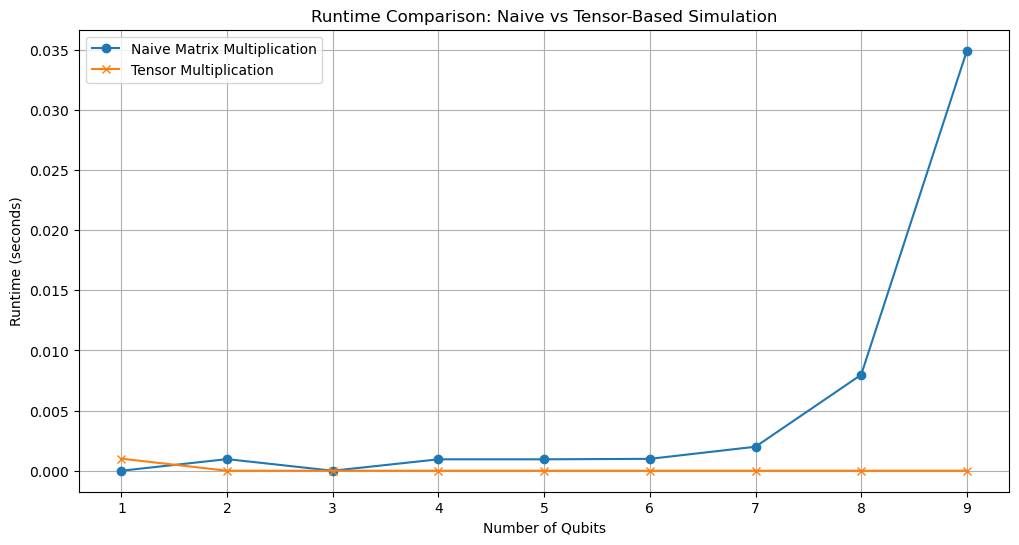

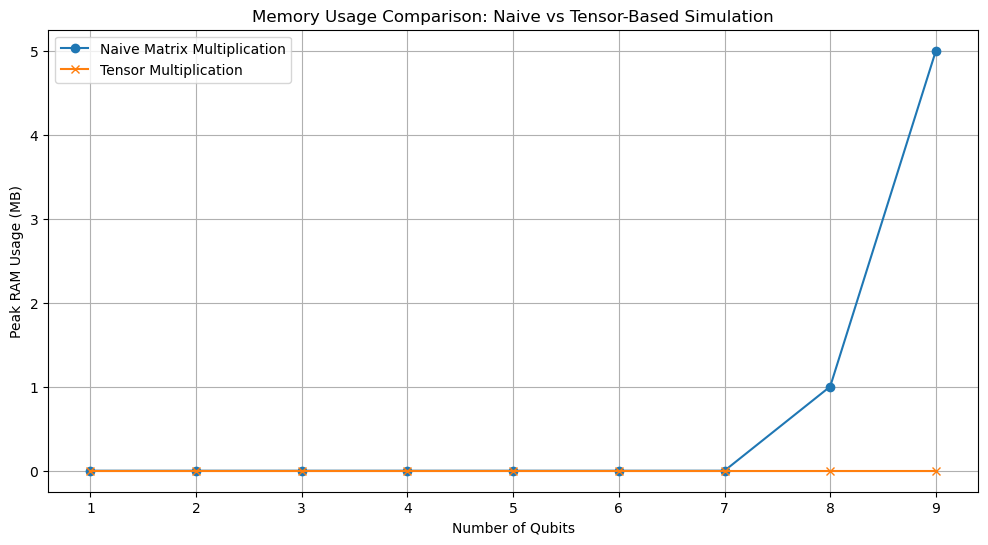

In [41]:
# Create 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Plot and save runtime comparison
plt.figure(figsize=(12, 6))
plt.plot(naive_qubits, runtimes_naive, marker='o', label='Naive Matrix Multiplication')
plt.plot(tensor_qubits, runtimes_tensor, marker='x', label='Tensor Multiplication')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison: Naive vs Tensor-Based Simulation')
plt.grid(True)
plt.legend()
plt.savefig('plots/runtime_comparison.png')  # Save the figure
plt.show()

# Plot and save memory usage comparison
plt.figure(figsize=(12, 6))
plt.plot(naive_qubits, memories_naive, marker='o', label='Naive Matrix Multiplication')
plt.plot(tensor_qubits, memories_tensor, marker='x', label='Tensor Multiplication')
plt.xlabel('Number of Qubits')
plt.ylabel('Peak RAM Usage (MB)')
plt.title('Memory Usage Comparison: Naive vs Tensor-Based Simulation')
plt.grid(True)
plt.legend()
plt.savefig('plots/memory_usage_comparison.png')  # Save the figure
plt.show()

### 3) Bonus Question

1. How would you sample from the final states in the statevector or tensor representations?  
2. And how about computing exact expectation values in the form $$ \langle \Psi | \text{Op} | \Psi \rangle $$?

#### Answer

**Sample Functions**
- `sample_statevector`: Samples outcomes from a quantum state represented as a state vector by calculating the probabilities $$ |\psi_i|^2 $$ for each basis state and drawing samples accordingly.
- `sample_tensor`: Flattens a tensor-based quantum state into a state vector, calculates probabilities $$ |\psi_i|^2 $$, and draws samples based on these probabilities.

**Compute Expectation Value Functions**
- `compute_expectation_value`: Calculates the expectation value $$ \langle \Psi | \text{Op} | \Psi \rangle $$ for a state vector $$ |\Psi\rangle $$ by applying the operator to the state and taking the inner product with its conjugate and transpose.
- `compute_expectation_value_tensor`: Flattens a tensor-based state into a vector and computes the expectation value using the same method as `compute_expectation_value`.


In [43]:
# Sample final states from statevector
def sample_statevector(state, num_samples=1000):
    probabilities = np.abs(state)**2
    outcomes = np.arange(len(state))
    samples = np.random.choice(outcomes, size=num_samples, p=probabilities)
    return samples

# Sample final states from tensor
def sample_tensor(state_tensor, num_samples=1000):
    state_vector = state_tensor.flatten()
    probabilities = np.abs(state_vector)**2
    outcomes = np.arange(len(state_vector))
    samples = np.random.choice(outcomes, size=num_samples, p=probabilities)
    return samples

# Compute expectation value for a given operator
def compute_expectation_value(state, operator):
    op_state = operator @ state
    return np.real(np.conjugate(state).T @ op_state)

# Compute expectation value for tensor representation
def compute_expectation_value_tensor(state_tensor, operator):
    return compute_expectation_value(state_tensor.flatten(), operator)

def test_sample_and_expectation():
    print("Testing sampling and expectation value functions...\n")
    n = 1
    state = np.array([1, 0], dtype=complex)  # |0> state
    samples = sample_statevector(state, num_samples=1000)
    print("Samples from |0⟩ state (expected 0's):", samples[:10])  # Show first 10 samples for brevity
    if np.all(samples == 0):
        print("Test 1 passed: Sampling from |0⟩ returns only |0⟩ state.\n")
    else:
        print("Test 1 failed: Unexpected samples from |0⟩ state.\n")

    state_tensor = np.array([1, 0], dtype=complex).reshape((2,))
    samples = sample_tensor(state_tensor, num_samples=1000)
    print("Samples from tensor |0⟩ state (expected 0's):", samples[:10])
    if np.all(samples == 0):
        print("Test 2 passed: Sampling from tensor |0⟩ returns only |0⟩ state.\n")
    else:
        print("Test 2 failed: Unexpected samples from tensor |0⟩ state.\n")

    z_gate = Z_gate()
    expected_value = 1  # Expected Z expectation for |0>
    computed_value = compute_expectation_value(state, z_gate)
    print("Computed expectation value for Z on |0⟩:", computed_value)
    if np.isclose(computed_value, expected_value):
        print("Test 3 passed: Expectation value of Z for |0⟩ is correct.\n")
    else:
        print("Test 3 failed: Expected", expected_value, "but got", computed_value, "\n")

    computed_value_tensor = compute_expectation_value_tensor(state_tensor, z_gate)
    print("Computed expectation value for Z on tensor |0⟩:", computed_value_tensor)
    if np.isclose(computed_value_tensor, expected_value):
        print("Test 4 passed: Expectation value of Z for tensor |0⟩ is correct.\n")
    else:
        print("Test 4 failed: Expected", expected_value, "but got", computed_value_tensor, "\n")

    state = np.array([0, 1], dtype=complex)  # |1> state
    samples = sample_statevector(state, num_samples=1000)
    print("Samples from |1⟩ state (expected 1's):", samples[:10])
    if np.all(samples == 1):
        print("Test 5 passed: Sampling from |1⟩ returns only |1⟩ state.\n")
    else:
        print("Test 5 failed: Unexpected samples from |1⟩ state.\n")

    state_tensor = np.array([0, 1], dtype=complex).reshape((2,))
    samples = sample_tensor(state_tensor, num_samples=1000)
    print("Samples from tensor |1⟩ state (expected 1's):", samples[:10])
    if np.all(samples == 1):
        print("Test 6 passed: Sampling from tensor |1⟩ returns only |1⟩ state.\n")
    else:
        print("Test 6 failed: Unexpected samples from tensor |1⟩ state.\n")

    expected_value = -1  # Expected Z expectation for |1>
    computed_value = compute_expectation_value(state, z_gate)
    print("Computed expectation value for Z on |1⟩:", computed_value)
    if np.isclose(computed_value, expected_value):
        print("Test 7 passed: Expectation value of Z for |1⟩ is correct.\n")
    else:
        print("Test 7 failed: Expected", expected_value, "but got", computed_value, "\n")

    computed_value_tensor = compute_expectation_value_tensor(state_tensor, z_gate)
    print("Computed expectation value for Z on tensor |1⟩:", computed_value_tensor)
    if np.isclose(computed_value_tensor, expected_value):
        print("Test 8 passed: Expectation value of Z for tensor |1⟩ is correct.\n")
    else:
        print("Test 8 failed: Expected", expected_value, "but got", computed_value_tensor, "\n")

test_sample_and_expectation()

Testing sampling and expectation value functions...

Samples from |0⟩ state (expected 0's): [0 0 0 0 0 0 0 0 0 0]
Test 1 passed: Sampling from |0⟩ returns only |0⟩ state.

Samples from tensor |0⟩ state (expected 0's): [0 0 0 0 0 0 0 0 0 0]
Test 2 passed: Sampling from tensor |0⟩ returns only |0⟩ state.

Computed expectation value for Z on |0⟩: 1.0
Test 3 passed: Expectation value of Z for |0⟩ is correct.

Computed expectation value for Z on tensor |0⟩: 1.0
Test 4 passed: Expectation value of Z for tensor |0⟩ is correct.

Samples from |1⟩ state (expected 1's): [1 1 1 1 1 1 1 1 1 1]
Test 5 passed: Sampling from |1⟩ returns only |1⟩ state.

Samples from tensor |1⟩ state (expected 1's): [1 1 1 1 1 1 1 1 1 1]
Test 6 passed: Sampling from tensor |1⟩ returns only |1⟩ state.

Computed expectation value for Z on |1⟩: -1.0
Test 7 passed: Expectation value of Z for |1⟩ is correct.

Computed expectation value for Z on tensor |1⟩: -1.0
Test 8 passed: Expectation value of Z for tensor |1⟩ is correct